## Data606 - Capstone Project
```
Group H
Malav Patel, Kent Butler
Prof. Unal Sokaglu
```

This project is about performing time-series analysis on climate data analysis data.



# Research

### References

Some explanations of earth sciences statistics:
https://pjbartlein.github.io/REarthSysSci/ltms-and-anomalies.html

NOAA PSL NCEP-NCAR datasets:  https://psl.noaa.gov/data/gridded/data.ncep.reanalysis.html

NOAA PSL, other recognized data sources directory: https://psl.noaa.gov/data/help/othersources/

Global environmental policy timeline, https://www.boell.de/en/2022/05/28/international-environmental-policy-timeline

OECD convergence of policy, climate,and economy: https://www.oecd.org/

NASA climate time machine: https://climate.nasa.gov/interactives/climate-time-machine

### Factoids

* All of the plastic waste produced in the world in 2019 alone weighs as much as 35,000 Eiffel Towers – 353 million tons  - [*Organization for Economic Cooperation and Development (OECD)*](https://www.boell.de/en/2022/05/28/international-environmental-policy-timeline)



## Application Parameters

Note: algorithm tuning is done with declaration of the model.

In [201]:
import pandas as pd
from datetime import datetime as dt
import datetime

In [202]:
debug = True

DRIVE_PATH = "/content/drive/MyDrive/data606"

# Set the location of this script in GDrive
SCRIPT_PATH = DRIVE_PATH + "/src/"

# Root Path of the data on the cloud drive
DATA_ROOT = DRIVE_PATH + "/data/"

# Model to use
MODEL_NAME = "LSTMv2"

# Location of logged output prediction data
LOG_PATH = DATA_ROOT + "/preds/"

# Journal file
JOURNAL_LOG = SCRIPT_PATH + "cv-results.csv"

# Number of samples to work with - will be split  into train/test
SAMPLE_SIZE = 5000

# Device to run on
run_on_device =  'cpu' # 'cuda'

# Start including data from this date
START_DATE =  pd.to_datetime(dt.fromisoformat('1950-01-01'))
# Stop including data after this date
END_DATE = pd.to_datetime(dt.fromisoformat('2015-12-01'))

---

**Model Configuration**

---

**Basic model params**

In [203]:
# History lookback in network
INPUT_WINDOW = 30
# How far forward to predict
LABEL_WINDOW = 1
# Ratio of test data to train data - used for split
TEST_RATIO = 0.2
# 0..1 percent of data to use as validation
VALIDATION_RATIO = 0.1
# Num epochs
NUM_EPOCHS = 30

**Configure Predictions**

In [204]:
# Label to predict
TARGET_LABEL = 'landSeaAvgTemp'

# Base dataset
TEMP_DATA = {'filename':'GlobalTemperatures.csv',
             'feature_map':{'LandAndOceanAverageTemperature':'landSeaAvgTemp'},
             'date_col':'dt'}
#TEMP_DATA = {'filename':'GlobalTemperatures.csv',
#              'feature_map':{'LandAverageTemperature':'landAvgTemp',	'LandMaxTemperature':'landMaxTemp',	'LandMinTemperature':'landMinTemp',	'LandAndOceanAverageTemperature':'landSeaAvgTemp'},
#               'date_col':'dt'}


# Datasets
CO2_DATA = {'filename':"atmospheric-co2.csv",
            'feature_map':{'Carbon Dioxide (ppm)':'co2', 'Seasonally Adjusted CO2 (ppm)':'co2_seas'},
            'date_map':{'Year':'year','Month':'month'}}

SEAICE_DATA = {'filename':"seaice.csv",
               'feature_map':{'     Extent':'ice_extent','    Missing':'ice_missing'},
               'date_map':{' Month':'month','Year':'year',' Day':'day'}}

WEATHER_DATA = {'filename':"finalDatasetWithRain.csv",
                'feature_map':{'air_x':'air_x','air_y':'air_y','uwnd':'uwnd'},
                'date_col':'time'}

VOLCANO_DATA = {'filename':'eruptions-conditioned.csv',
                'feature_map':{'vei':'volcanic_idx'},
                'date_map':{'start_year':'year','start_month':'month'}}

FOREST_DATA = {'filename':'WorldForestCover.csv',
               'feature_map':{'PctCover':'pct_forest_cover'},
               'date_map':{'Year':'year'}}

SUNSPOT_DATA = {'filename':'sunspotnumber.csv',
               'feature_map':{'suns_spot_number':'sunspot_num'},
               'date_map':{'year':'year'}}

POLICY_DATA = {'filename':'GlobalEnvPolicies.csv',
               'feature_map':{'EventRating':'policy_rate'},
               'date_col':'date'}

#GHG_DATA = {'filename':'greenhouse_gas_inventory_data.csv',
#            'feature_map':{''},
#            'date_map':{'Year':'year'}}
#ALL_DATASETS = []
#ALL_DATASETS = [SUNSPOT_DATA]
#ALL_DATASETS = [FOREST_DATA]
#ALL_DATASETS = [CO2_DATA, SEAICE_DATA]
#ALL_DATASETS = [CO2_DATA, SEAICE_DATA, WEATHER_DATA]
#ALL_DATASETS = [CO2_DATA, SEAICE_DATA, VOLCANO_DATA]
#ALL_DATASETS = [CO2_DATA, SEAICE_DATA, WEATHER_DATA, VOLCANO_DATA]
#ALL_DATASETS = [CO2_DATA, SEAICE_DATA, WEATHER_DATA, VOLCANO_DATA, FOREST_DATA]
ALL_DATASETS = [CO2_DATA, SEAICE_DATA, WEATHER_DATA, VOLCANO_DATA, FOREST_DATA, SUNSPOT_DATA]
#ALL_DATASETS = [VOLCANO_DATA, FOREST_DATA, SUNSPOT_DATA]
#ALL_DATASETS = [VOLCANO_DATA, FOREST_DATA, SUNSPOT_DATA, CO2_DATA]
#ALL_DATASETS = [VOLCANO_DATA, FOREST_DATA, SUNSPOT_DATA, CO2_DATA, SEAICE_DATA]
#ALL_DATASETS = [CO2_DATA, SEAICE_DATA, VOLCANO_DATA, FOREST_DATA, SUNSPOT_DATA]

#ALL_DATASETS = [POLICY_DATA,CO2_DATA]


In [205]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [206]:
%cd $SCRIPT_PATH

/content/drive/MyDrive/data606/src


In [207]:
# Load util class
%run -i "./ProjectUtil.ipynb"

In [208]:
# Load util class
#%run -i "./WindowGenerator.ipynb"

# Data Load

In [209]:
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.rcParams["figure.figsize"] = (10,6)
import warnings

In [210]:
warnings.filterwarnings('ignore')
plt.style.use('seaborn')
%matplotlib inline

---

**Initial Data Load**

---

In [211]:
# Load util class
%run -i "./Dataset_Merger.ipynb"

In [212]:
# Declare a merger compatible with our source data and our target dataset we want to merge into
merger = Dataset_Merger(data_path=DATA_ROOT, start_date=START_DATE, end_date=END_DATE, debug=True)

------------------------------------------
 ###  ============================================================
  Loading data/content/drive/MyDrive/data606/data/GlobalTemperatures.csv

 ### Defaulting df_aggr to reference df
------------------------------------------
 ### Renaming columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3192 entries, 0 to 3191
Data columns (total 9 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   dt                                         3192 non-null   object 
 1   LandAverageTemperature                     3180 non-null   float64
 2   LandAverageTemperatureUncertainty          3180 non-null   float64
 3   LandMaxTemperature                         1992 non-null   float64
 4   LandMaxTemperatureUncertainty              1992 non-null   float64
 5   LandMinTemperature                         1992 non-null   float64
 6   LandMinTemperatureUncert

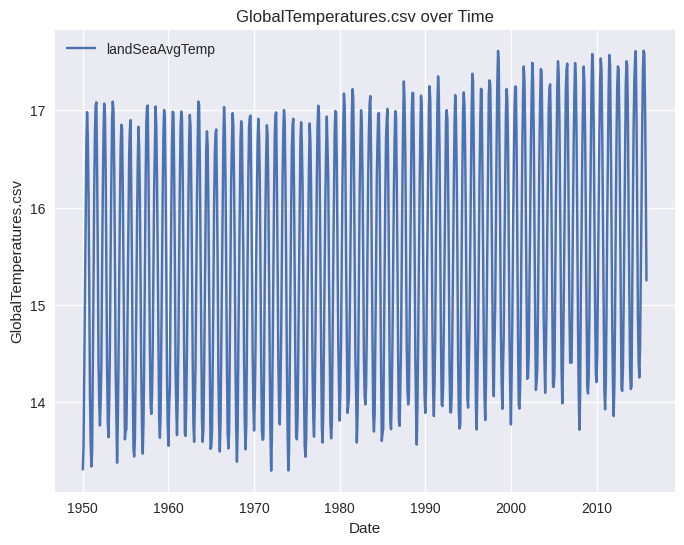

In [213]:
# Start by merging initial dataset
df_merge = merger.merge_dataset(TEMP_DATA['filename'],
                                TEMP_DATA['feature_map'],
                                 date_col=TEMP_DATA['date_col'])

In [214]:
print(assess_na(df_merge))

  _date_  day year month landSeaAvgTemp
0    0.0  0.0  0.0   0.0            0.0


---

**Merge Additional Data**

---

------------------------------------------
 ###  ============================================================
  Loading data/content/drive/MyDrive/data606/data/atmospheric-co2.csv

------------------------------------------
 ### Renaming columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 7 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   year                               720 non-null    int64  
 1   month                              720 non-null    int64  
 2   Decimal Date                       720 non-null    float64
 3   co2                                703 non-null    float64
 4   co2_seas                           703 non-null    float64
 5   Carbon Dioxide Fit (ppm)           707 non-null    float64
 6   Seasonally Adjusted CO2 Fit (ppm)  707 non-null    float64
dtypes: float64(5), int64(2)
memory usage: 39.5 KB
-----------------------

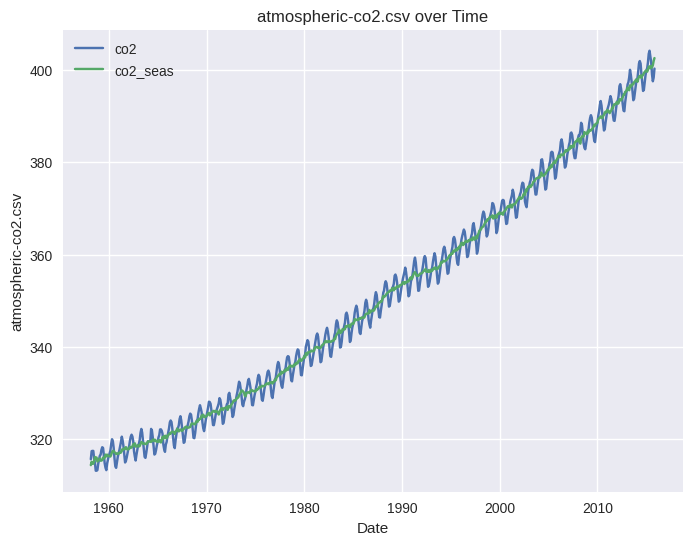

  _date_  day year month landSeaAvgTemp       co2  co2_seas
0    0.0  0.0  0.0   0.0            0.0  0.123894  0.123894
------------------------------------------
 ###  ============================================================
  Loading data/content/drive/MyDrive/data606/data/seaice.csv

------------------------------------------
 ### Renaming columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26354 entries, 0 to 26353
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          26354 non-null  int64  
 1   month         26354 non-null  int64  
 2   day           26354 non-null  int64  
 3   ice_extent    26354 non-null  float64
 4   ice_missing   26354 non-null  float64
 5    Source Data  26354 non-null  object 
 6   hemisphere    26354 non-null  object 
dtypes: float64(2), int64(3), object(2)
memory usage: 1.4+ MB
------------------------------------------
 ### preprocess_dates with date_col: None
-

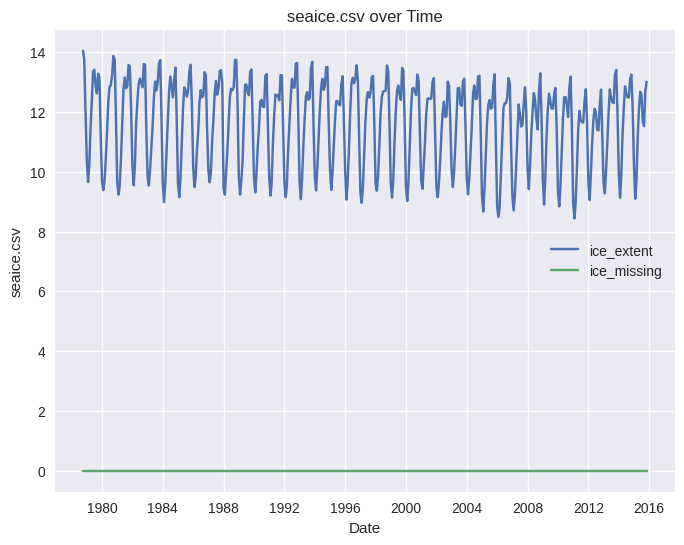

  _date_  day year month landSeaAvgTemp       co2  co2_seas ice_extent  \
0    0.0  0.0  0.0   0.0            0.0  0.123894  0.123894   0.436157   

  ice_missing  
0    0.436157  
------------------------------------------
 ###  ============================================================
  Loading data/content/drive/MyDrive/data606/data/finalDatasetWithRain.csv

------------------------------------------
 ### Renaming columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 622392 entries, 0 to 622391
Data columns (total 71 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   lat       622392 non-null  float64
 1   lon       622392 non-null  float64
 2   time      622392 non-null  object 
 3   air_x     622392 non-null  float64
 4   air_y     311196 non-null  float64
 5   air       0 non-null       float64
 6   lftx4     311196 non-null  float64
 7   cfnlf     622392 non-null  float64
 8   cfnsf     622392 non-null  float64
 9   pres_x    32

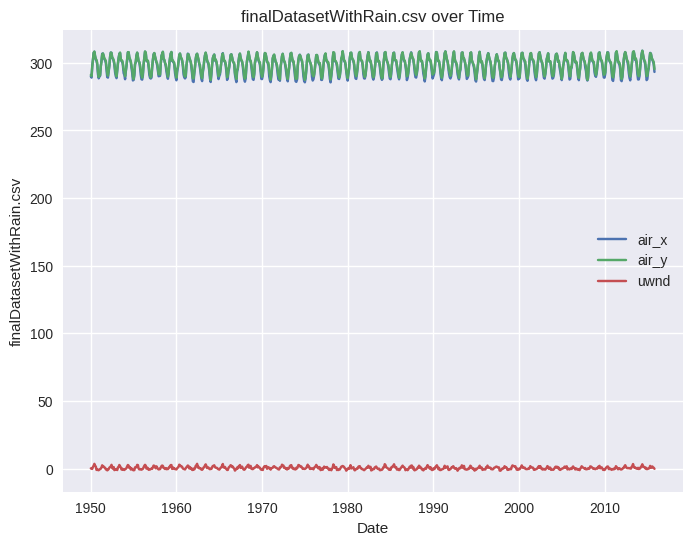

  _date_  day year month landSeaAvgTemp       co2  co2_seas ice_extent  \
0    0.0  0.0  0.0   0.0            0.0  0.123894  0.123894   0.436157   

  ice_missing air_x air_y uwnd  
0    0.436157   0.0   0.0  0.0  
------------------------------------------
 ###  ============================================================
  Loading data/content/drive/MyDrive/data606/data/eruptions-conditioned.csv

------------------------------------------
 ### Renaming columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6221 entries, 0 to 6220
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              6221 non-null   int64  
 1   volcano_number          6221 non-null   int64  
 2   volcano_name            6221 non-null   object 
 3   eruption_number         6221 non-null   int64  
 4   eruption_category       6221 non-null   object 
 5   area_of_activity        2604 non-null   object 
 6

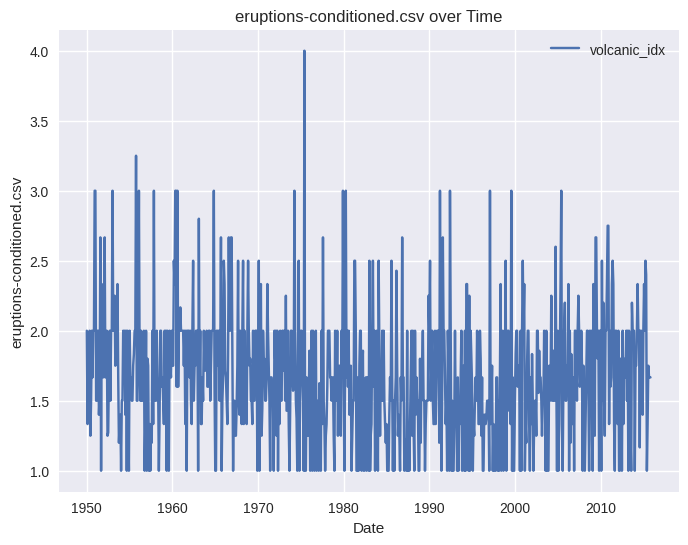

  _date_  day year month landSeaAvgTemp       co2  co2_seas ice_extent  \
0    0.0  0.0  0.0   0.0            0.0  0.123894  0.123894   0.436157   

  ice_missing air_x air_y uwnd volcanic_idx  
0    0.436157   0.0   0.0  0.0          0.0  
------------------------------------------
 ###  ============================================================
  Loading data/content/drive/MyDrive/data606/data/WorldForestCover.csv

------------------------------------------
 ### Renaming columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 860 entries, 0 to 859
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   year              860 non-null    int64  
 1   Country           860 non-null    object 
 2   TotalArea         860 non-null    float64
 3   CoverArea         860 non-null    int64  
 4   pct_forest_cover  860 non-null    float64
dtypes: float64(2), int64(2), object(1)
memory usage: 33.7+ KB
----------------

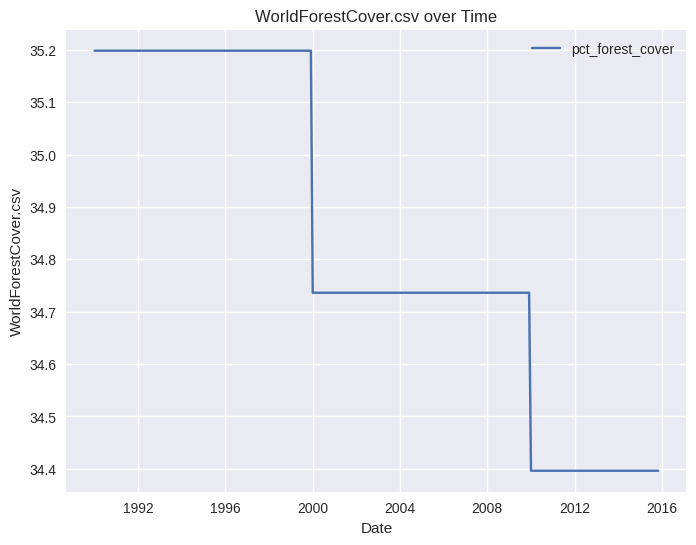

  _date_  day year month landSeaAvgTemp       co2  co2_seas ice_extent  \
0    0.0  0.0  0.0   0.0            0.0  0.123894  0.123894   0.436157   

  ice_missing air_x air_y uwnd volcanic_idx pct_forest_cover  
0    0.436157   0.0   0.0  0.0          0.0         0.606827  
------------------------------------------
 ###  ============================================================
  Loading data/content/drive/MyDrive/data606/data/sunspotnumber.csv

------------------------------------------
 ### Renaming columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315 entries, 0 to 314
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   year         315 non-null    int64  
 1   sunspot_num  315 non-null    float64
 2   Unnamed: 2   0 non-null      float64
 3   Unnamed: 3   0 non-null      float64
 4   Unnamed: 4   0 non-null      float64
 5   Unnamed: 5   0 non-null      float64
 6   Unnamed: 6   0 non-null      float6

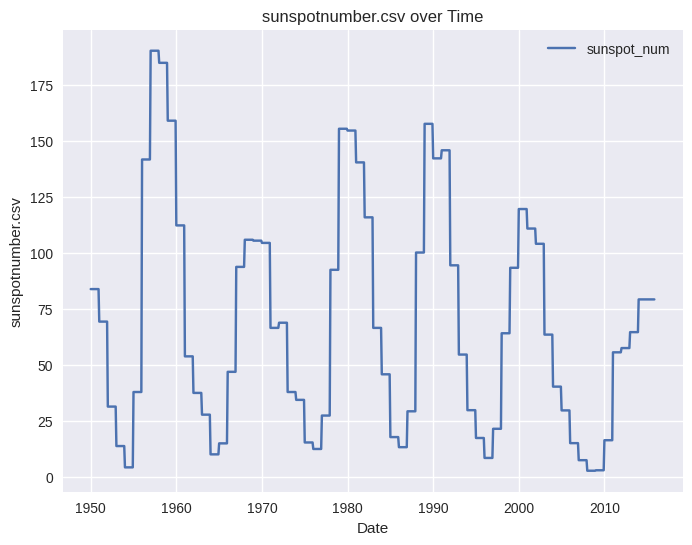

  _date_  day year month landSeaAvgTemp       co2  co2_seas ice_extent  \
0    0.0  0.0  0.0   0.0            0.0  0.123894  0.123894   0.436157   

  ice_missing air_x air_y uwnd volcanic_idx pct_forest_cover sunspot_num  
0    0.436157   0.0   0.0  0.0          0.0         0.606827         0.0  


In [215]:
for dataset in ALL_DATASETS:
  if ('date_map' in dataset):
    df_merge = merger.merge_dataset(dataset['filename'],
                                    feature_map=dataset['feature_map'],
                                    df_aggr=df_merge,
                                    date_map=dataset['date_map'])
  else:
    df_merge = merger.merge_dataset(dataset['filename'],
                                feature_map=dataset['feature_map'],
                                df_aggr=df_merge,
                                date_col=dataset['date_col'])
  print(assess_na(df_merge))

In [216]:
df_merge

,_date_,day,year,month,landSeaAvgTemp,co2,co2_seas,ice_extent,ice_missing,air_x,air_y,uwnd,volcanic_idx,pct_forest_cover,sunspot_num
0,1950-01-01,1.0,1950,1,13.311,NaN,NaN,NaN,NaN,289.936261,290.994544,0.220916,2.000000,NaN,83.9
1,1950-02-01,1.0,1950,2,13.554,NaN,NaN,NaN,NaN,289.002692,290.035596,-0.067231,1.333333,NaN,83.9
2,1950-03-01,1.0,1950,3,14.296,NaN,NaN,NaN,NaN,297.095738,296.936238,-0.181692,1.666667,NaN,83.9
3,1950-04-01,1.0,1950,4,15.093,NaN,NaN,NaN,NaN,302.377345,302.449196,1.313697,1.666667,NaN,83.9
4,1950-05-01,1.0,1950,5,16.033,NaN,NaN,NaN,NaN,307.291194,307.264517,2.175056,2.000000,NaN,83.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,2015-07-01,1.0,2015,7,17.611,401.60,400.76,12.576548,0.0,303.987030,304.114913,0.649732,1.333333,34.396326,79.3
787,2015-08-01,1.0,2015,8,17.589,399.00,400.51,11.674048,0.0,302.203831,302.469150,1.620498,1.750000,34.396326,79.3
788,2015-09-01,1.0,2015,9,17.049,397.50,400.98,11.529883,0.0,300.948820,301.557981,1.038612,1.666667,34.396326,79.3
789,2015-10-01,1.0,2015,10,16.290,398.28,401.90,12.687742,0.0,298.714987,300.453620,0.634611,1.666667,34.396326,79.3


---

**Assess correlations**

---

In [217]:
# Assess correlations between all data columns
df_corr = df_merge.corr()

In [218]:
# Identify the columns which have medium to strong correlation with target
df_corr_cols = df_corr[df_corr[TARGET_LABEL] > 0.5]

In [219]:
# Drop the target from the correlation results in case we want to use this reduced set
#    in place of the full set
df_corr_cols = df_corr_cols.drop(columns=[])

In [220]:
# Extract just the column names
corr_cols = df_corr_cols.index.values

In [221]:
if debug:
  print(corr_cols)

['landSeaAvgTemp' 'ice_extent' 'air_x' 'air_y' 'uwnd']


Text(0.5, 1.0, 'Heatmap of correlation among variables')

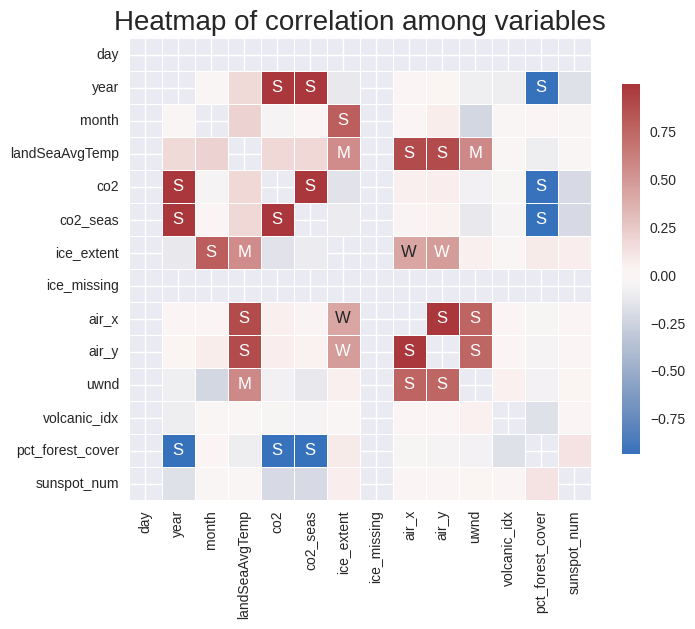

In [222]:
# Add labels
labels = np.where(np.abs(df_corr) > 0.75, 'S',
                  np.where(np.abs(df_corr) > 0.5, 'M',
                           np.where(np.abs(df_corr) > 0.25, 'W', '')))
# Plot the matrix
plt.figure(figsize=(8,6))
sns.heatmap(df_corr, mask=np.eye(len(df_corr)), square=True,
            center=0, annot=labels, fmt = '', linewidths = .5,
            cmap='vlag', cbar_kws={'shrink':0.8});
plt.title('Heatmap of correlation among variables', fontsize=20)

---

**Prepare for Modeling**

---

In [223]:
# It's time to set date as index and remove from dataset
df_merge.set_index(merger.DATE_COL, inplace=True, drop=True)

In [224]:
df_merge

,day,year,month,landSeaAvgTemp,co2,co2_seas,ice_extent,ice_missing,air_x,air_y,uwnd,volcanic_idx,pct_forest_cover,sunspot_num
_date_,,,,,,,,,,,,,,
1950-01-01,1.0,1950,1,13.311,NaN,NaN,NaN,NaN,289.936261,290.994544,0.220916,2.000000,NaN,83.9
1950-02-01,1.0,1950,2,13.554,NaN,NaN,NaN,NaN,289.002692,290.035596,-0.067231,1.333333,NaN,83.9
1950-03-01,1.0,1950,3,14.296,NaN,NaN,NaN,NaN,297.095738,296.936238,-0.181692,1.666667,NaN,83.9
1950-04-01,1.0,1950,4,15.093,NaN,NaN,NaN,NaN,302.377345,302.449196,1.313697,1.666667,NaN,83.9
1950-05-01,1.0,1950,5,16.033,NaN,NaN,NaN,NaN,307.291194,307.264517,2.175056,2.000000,NaN,83.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-07-01,1.0,2015,7,17.611,401.60,400.76,12.576548,0.0,303.987030,304.114913,0.649732,1.333333,34.396326,79.3
2015-08-01,1.0,2015,8,17.589,399.00,400.51,11.674048,0.0,302.203831,302.469150,1.620498,1.750000,34.396326,79.3
2015-09-01,1.0,2015,9,17.049,397.50,400.98,11.529883,0.0,300.948820,301.557981,1.038612,1.666667,34.396326,79.3


**Assess Periodicity**

```
# removed kendalltau analysis
# Replace with fft graph of major freqs?
```


**Resampling**

This is being performed during the dataset merging phase.

Ready for time series modeling.

---

**Data conversion for model**

---

**Extract labels**

Time series creates a supervised learning problem out of moving data.

**Dataset stats**

In [225]:
NUM_FEATURES = len(df_merge.columns)

# Capture stats on number of non-metadata columns - so, exclude some stuff
#NET_NUM_FEATURES = len(set(df_merge.columns) - set(['year','month','day']))

In [226]:
# Keep rows aside for post validation?
TOTAL_ROWS = df_merge.shape[0]
NUM_VALIDATION = math.floor(TOTAL_ROWS * VALIDATION_RATIO)
WORKING_ROWS = TOTAL_ROWS - NUM_VALIDATION

In [227]:
# Split non-validation rows into train/test
NUM_TEST = math.floor(WORKING_ROWS * TEST_RATIO)
NUM_TRAIN = WORKING_ROWS - NUM_TEST

In [228]:
print(f'Num features: {NUM_FEATURES}')
print(f'Total rows: {TOTAL_ROWS}')
print(f'Validation rows: {NUM_VALIDATION}')
print(f'Train rows: {NUM_TRAIN}')
print(f'Test rows: {NUM_TEST}')

Num features: 14
Total rows: 791
Validation rows: 79
Train rows: 570
Test rows: 142


**Split into Train/Test**

In [229]:
df_train = df_merge.iloc[:NUM_TRAIN, :]
df_val = df_merge.iloc[NUM_TRAIN:NUM_TRAIN+NUM_VALIDATION, :]
df_test = df_merge.iloc[NUM_TRAIN+NUM_VALIDATION:, :]

In [230]:
y_train = df_train[TARGET_LABEL]
y_val = df_val[TARGET_LABEL]
y_test = df_test[TARGET_LABEL]

In [231]:
if debug:
  print(f'df_train: {df_train.shape}')
  print(f'y_train: {y_train.shape}')
  print(f'df_test: {df_test.shape}')
  print(f'y_test: {y_test.shape}')
  print(f'df_val: {df_val.shape}')
  print(f'y_val: {y_val.shape}')

df_train: (570, 14)
y_train: (570,)
df_test: (142, 14)
y_test: (142,)
df_val: (79, 14)
y_val: (79,)


**Scale data**

Doing this **after** the split means that training data doesn't get unfair advantage of looking ahead into the 'future' during test & validation.

In [232]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [233]:
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer,  QuantileTransformer, Normalizer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import tensorflow as tf


In [234]:
# Create small pipeline for numerical features
numeric_pipeline = Pipeline(steps = [('impute', SimpleImputer(strategy='mean')),
                                    ('scale', MinMaxScaler())])

In [235]:
# get names of numerical features
con_lst = df_train.select_dtypes(include='number').columns.to_list()

In [236]:
# Transformer for applying Pipelines
column_transformer = ColumnTransformer(transformers = [('number', numeric_pipeline, con_lst)])

In [237]:
# Transform data features
X_train_tx = column_transformer.fit_transform(df_train)
X_test_tx = column_transformer.transform(df_test)
X_val_tx = column_transformer.transform(df_val)
X_train_tx.shape, X_test_tx.shape, X_val_tx.shape

((570, 14), (142, 14), (79, 14))

In [238]:
# Transform labels
label_scaler = MinMaxScaler()
y_train_tx = label_scaler.fit_transform(y_train.values.reshape(-1, 1))

In [239]:
# Slice labels - we cannot predict anything inside the first INPUT_WINDOW
y_train_tx = y_train_tx[INPUT_WINDOW:]

In [240]:
if debug:
  print(f'X_train_tx {X_train_tx.shape}: {X_train_tx[0]}')
  print(f'y_train_tx {y_train_tx.shape}: {y_train_tx[0]}')

X_train_tx (570, 14): [0.         0.         0.         0.00318862 0.43272801 0.44556086
 0.54766045 0.         0.19365674 0.1762533  0.33617958 0.33333333
 0.         0.42787944]
y_train_tx (540, 1): [0.92469953]


**Extract X and y**

Normally we would do this by explicitly extracting data from our df.

However for a time series, we're going to create many small supervised learning sets, so a set of X and y pairs.

We should end up with data in a shape ready for batched network input:

`batches X time_steps X features`



In [241]:
#windowing = TfWindowGenerator(input_width=INPUT_WINDOW,
#                              label_width=LABEL_WINDOW,
#                              shift=LABEL_WINDOW,
#                              label_columns=[TARGET_LABEL])

In [242]:
# Pull X and y out of Training data
#X, y = windowing.generate(df_train)

In [243]:
# testing more direct extraction
#X = np.asarray(df.drop(columns=[TARGET_LABEL]))
#X = np.asarray(df)

In [244]:
if debug:
  print(f'X_train_tx: {X_train_tx.shape}')
  print(f'y_train_tx: {y_train_tx.shape}')

X_train_tx: (570, 14)
y_train_tx: (540, 1)


---

**Modeling**

---

In [245]:
# These are the features we are going to be modeling
COLS = list(df_merge.columns)

**Slice into Batches**

In [246]:
#ds = windowing.make_dataset(X, y)

In [247]:
# Use tensorflow util to batch the timeseries
#   note that targets assume first label starts at 0 (vs. targets[INPUT_WINDOW])
ds = tf.keras.utils.timeseries_dataset_from_array(
    data=X_train_tx,
    targets=y_train_tx,
    batch_size=INPUT_WINDOW*2,
    sequence_length=INPUT_WINDOW    )

**Prep GPU**

In [248]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


---

**Build and Train**

---

**Build model**

In [249]:
# Load model class
%run -i "./Model_LSTMv2.ipynb"

In [250]:
model = ModelLSTMv2(window_size=INPUT_WINDOW, num_epochs=NUM_EPOCHS, debug=True)

### Building ModelLSTMv2::


**Train model**

In [251]:
#model.train(X, y, NUM_FEATURES)
model_history = model.train(dataset=ds, num_features=NUM_FEATURES)

Epoch 1/30
9/9 [==============================] - 12s 27ms/step - loss: 0.2772
Epoch 2/30
9/9 [==============================] - 0s 22ms/step - loss: 0.1039
Epoch 3/30
9/9 [==============================] - 0s 23ms/step - loss: 0.0580
Epoch 4/30
9/9 [==============================] - 0s 19ms/step - loss: 0.0495
Epoch 5/30
9/9 [==============================] - 0s 22ms/step - loss: 0.0698
Epoch 6/30
9/9 [==============================] - 0s 21ms/step - loss: 0.0589
Epoch 7/30
9/9 [==============================] - 0s 22ms/step - loss: 0.0543
Epoch 8/30
9/9 [==============================] - 0s 22ms/step - loss: 0.0477
Epoch 9/30
9/9 [==============================] - 0s 23ms/step - loss: 0.0403
Epoch 10/30
9/9 [==============================] - 0s 22ms/step - loss: 0.0620
Epoch 11/30
9/9 [==============================] - 0s 31ms/step - loss: 0.0651
Epoch 12/30
9/9 [==============================] - 0s 29ms/step - loss: 0.0439
Epoch 13/30
9/9 [==============================] - 0s 36ms/s

In [252]:
# Capture stat
num_epochs = len(model_history.history['loss'])

**Test Predictions**

In [253]:
num_predictions = y_test.shape[0]-INPUT_WINDOW-LABEL_WINDOW
print(f'Num Exp. Predictions: {num_predictions} == {y_test.shape[0]} - {INPUT_WINDOW}')

preds = []
pred_dates = []
y_test_vals = []

Num Exp. Predictions: 111 == 142 - 30


In [254]:
for p in range(num_predictions):
  print(f'Pred range: x_test_tx[{p}:{p+INPUT_WINDOW}]')
  X_pred = X_test_tx[p:p+INPUT_WINDOW,:].reshape(-1, INPUT_WINDOW, NUM_FEATURES)
  label_index = p+INPUT_WINDOW+LABEL_WINDOW-1
  print(f'Exp output: y_test[{label_index}]')
  print(f'Pred date: {df_test.index[label_index]}')
  y_test_vals.append(y_test[label_index])
  # Predict
  pred = model.predict(X_pred)
  print(type(pred))
  print(pred.shape)
  # Scale and save
  val = label_scaler.inverse_transform(pred)
  preds.append(label_scaler.inverse_transform(pred))
  pred_dates.append(df_test.index[label_index].strftime('%Y-%m-%d'))


Pred range: x_test_tx[0:30]
Exp output: y_test[30]
Pred date: 2006-08-01 00:00:00
1/1 [==============================] - 2s 2s/step
<class 'numpy.ndarray'>
(1, 1)
Pred range: x_test_tx[1:31]
Exp output: y_test[31]
Pred date: 2006-09-01 00:00:00
1/1 [==============================] - 0s 23ms/step
<class 'numpy.ndarray'>
(1, 1)
Pred range: x_test_tx[2:32]
Exp output: y_test[32]
Pred date: 2006-10-01 00:00:00
1/1 [==============================] - 0s 20ms/step
<class 'numpy.ndarray'>
(1, 1)
Pred range: x_test_tx[3:33]
Exp output: y_test[33]
Pred date: 2006-11-01 00:00:00
1/1 [==============================] - 0s 21ms/step
<class 'numpy.ndarray'>
(1, 1)
Pred range: x_test_tx[4:34]
Exp output: y_test[34]
Pred date: 2006-12-01 00:00:00
1/1 [==============================] - 0s 20ms/step
<class 'numpy.ndarray'>
(1, 1)
Pred range: x_test_tx[5:35]
Exp output: y_test[35]
Pred date: 2007-01-01 00:00:00
1/1 [==============================] - 0s 21ms/step
<class 'numpy.ndarray'>
(1, 1)
Pred range: 

In [255]:
preds = np.array(preds).reshape(num_predictions)

**Analyze results**

In [256]:
df_results = pd.DataFrame({'y_test': y_test_vals,
                          'preds': preds,
                           'pred_dates':pred_dates},
                           index=[i+1 for i in range(num_predictions)])

In [257]:
df_results

,y_test,preds,pred_dates
1,17.479,16.777349,2006-08-01
2,16.792,16.511688,2006-09-01
3,15.935,15.716811,2006-10-01
4,14.931,14.571507,2006-11-01
5,14.407,14.145873,2006-12-01
...,...,...,...
107,17.390,16.736044,2015-06-01
108,17.611,16.813389,2015-07-01
109,17.589,16.795036,2015-08-01
110,17.049,16.617685,2015-09-01


In [258]:
df_results.shape

(111, 3)

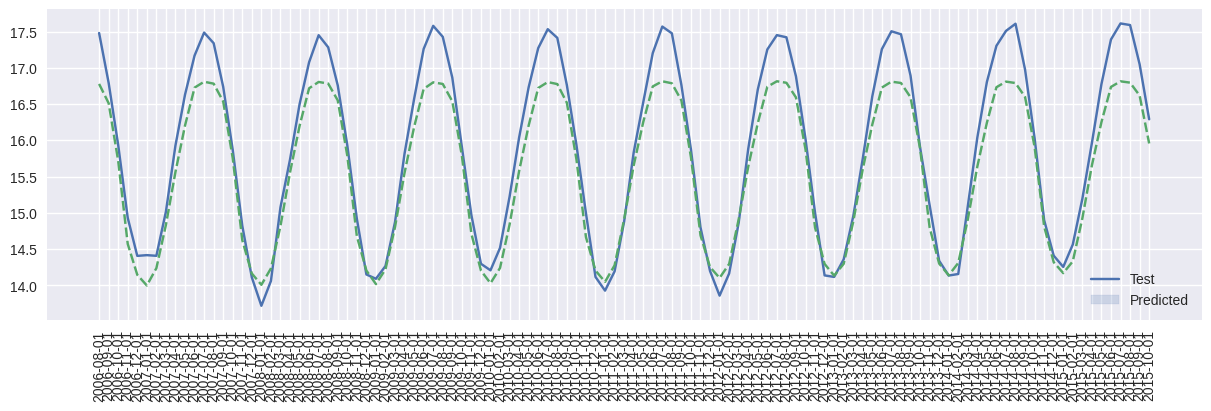

In [259]:
# Plot results
# max points - default to full set
MAX_PTS=df_results.shape[0]
#MAX_PTS=24
fig, ax = plt.subplots(figsize=(12,4), layout="constrained")
#plt.plot(y_test_vals, 'blue', linewidth=5)
#plt.plot(preds,'r', linewidth=4)
sns.lineplot(data=df_results[:MAX_PTS], ax=ax)
ax.set_xticks(df_results.index[:MAX_PTS], labels=pred_dates[:MAX_PTS], rotation=90)
plt.legend(('Test','Predicted'))

In [260]:
#plt.figure(figsize=(12,6))
#plt.plot(y_test_vals, 'blue', linewidth=2)
#plt.plot(preds,'g' , linewidth=2)
#plt.legend(('Test','Predicted'))
#plt.show()

In [261]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [262]:
# Calculate MAPE
m = tf.keras.metrics.MeanAbsolutePercentageError()
m.update_state(y_test_vals, preds)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=1.0>

In [263]:
mse = mean_squared_error(y_test_vals, preds)
mae = mean_absolute_error(y_test_vals, preds)
mape = m.result().numpy()/100  # adjust Keras output to match scikit
from sklearn.metrics import mean_absolute_percentage_error
sk_mape = mean_absolute_percentage_error(y_test_vals, preds)

In [264]:
print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')
print(f'SKMAPE: {sk_mape}')

MSE: 0.15237021966498307
MAE: 0.32156028266425624
MAPE: 0.0195056688785553
SKMAPE: 0.0195056703625369


**Journal entry**

In [265]:
import csv

In [266]:
def current_time_ms():
  return dt.now().microsecond

In [267]:
serial = current_time_ms()

In [268]:
# write pred results out
df_results.to_csv(LOG_PATH +  f'model-preds-{serial}.csv', index_label='index')

In [269]:
# Save model
model.save_model(LOG_PATH, serial)

Saving model to: /content/drive/MyDrive/data606/data//preds/20231114-2349-LSTMv2-112516.hdf5


In [270]:
with open(JOURNAL_LOG, 'a') as csvfile:
  writer = csv.writer(csvfile)
  #writer.writerow(['DateTime','Serial','Model','TargetLabel','NumFeatures','WindowSize','TestPct','NumEpochs','MSE','MAE','MAPE','SKMAPE','Columns'])
  writer.writerow([dt.today().strftime("%Y%m%d-%H%M"),serial,MODEL_NAME,TARGET_LABEL,NUM_FEATURES,INPUT_WINDOW,TEST_RATIO,num_epochs,mse,mae,mape,sk_mape,COLS])